In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-16 06:58:10.370728: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 06:58:10.400060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 06:58:10.844044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/RJ_Reconstrucao_Sciaenidae_2024_08_06.xlsx')

df_Corvina = pd.DataFrame(df[['Ano','Corvina_art','Corvina_ind','Corvina_art_ind']])

#Somando art e ind em art_ind
for i in range(len(df_Corvina['Ano'])):
  if pd.isnull(df_Corvina.iloc[i,3])==True and pd.isnull(df_Corvina.iloc[i,2])==False and pd.isnull(df_Corvina.iloc[i,1])==False:
    df_Corvina.iloc[i,3] = df_Corvina.iloc[i,2] + df_Corvina.iloc[i,1] 


dados = df_Corvina[['Ano','Corvina_art','Corvina_art_ind']].dropna().reset_index(drop=True)

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Corvina_art'] = dados.loc[i,'Corvina_art'] / dados.loc[i,'Corvina_art_ind']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1962,1963,1964,1966,1967,1968,1969,1970,1971,1972,1973,1975,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Corvina_art'].values

dados.head()

,Ano,Corvina_art,Corvina_art_ind,Prop_Corvina_art
0,1978,583.0,771.0,0.756161
1,1979,431.0,594.0,0.725589
2,1980,414.0,1099.0,0.376706
3,1981,420.0,805.0,0.521739
4,1982,780.0,1253.0,0.622506


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=150, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Corvina/pesos prop art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Corvina/pesos prop art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Previsões dos dados ausentes: [[0.7645134 ]
 [0.7573182 ]
 [0.750123  ]
 [0.73581755]
 [0.7285564 ]
 [0.7212951 ]
 [0.7140755 ]
 [0.7068888 ]
 [0.69970584]
 [0.6925404 ]
 [0.68536735]
 [0.6710923 ]
 [0.6639993 ]
 [0.6569522 ]]


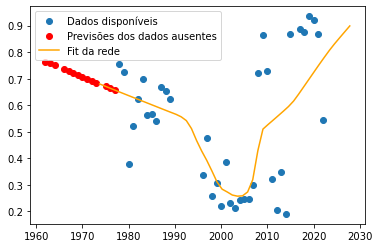

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

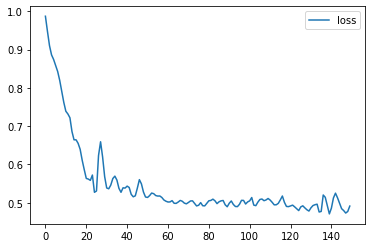

In [7]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [7]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1


df_preenchido = df[['Ano','Corvina_art']]
for i in range(len(prev_continua)):
    if i+1950 in anos_para_prever:
      df_preenchido.loc[i,'Corvina_art']=df.loc[i,'Corvina_art_ind']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Peixes/Sciaenidae/Corvina/Previsão Corvina_art_1962-1977.xlsx')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  Corvina_art
0   1950          NaN
1   1951          NaN
2   1952          NaN
3   1953          NaN
4   1954          NaN
5   1955          NaN
6   1956          NaN
7   1957          NaN
8   1958          NaN
9   1959          NaN
10  1960          NaN
11  1961          NaN
12  1962  3432.665039
13  1963  4133.442871
14  1964  3497.073486
15  1965          NaN
16  1966  3136.790283
17  1967  4997.168457
18  1968  5806.425781
19  1969  4982.818848
20  1970  4415.227539
21  1971  4632.752441
22  1972  5421.206543
23  1973  4763.988281
24  1974          NaN
25  1975   224.144821
26  1976   601.583374
27  1977  1035.356689
28  1978   583.000000
29  1979   431.000000
30  1980   414.000000
31  1981   420.000000
32  1982   780.000000
33  1983   932.000000
34  1984   675.000000
35  1985  1076.000000
36  1986  1269.000000
37  1987  1386.000000
38  1988  1245.000000
39  1989  1308.000000
40  1990          NaN
41  1991          NaN
42  1992        

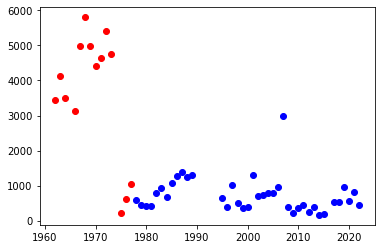

In [8]:
for i in range(len(df_preenchido['Ano'])):
  if i+1950 in anos_para_prever:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Corvina_art'].values[i],color='red')
  else:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Corvina_art'].values[i],color='blue')